In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm

In [3]:
# Arima
import itertools
import statsmodels.api as sm
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

In [131]:
# Perceptron
import dill
from perceptron import Perceptron

In [4]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.filterwarnings("ignore")

In [5]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
%matplotlib inline
pd.plotting.register_matplotlib_converters()
plt.rcParams['figure.figsize']=(14,8)
import seaborn
seaborn.set
seaborn.set_style("whitegrid")

In [6]:
def gerar_janelas(lista, tam):
    '''(np.array, int) -> np.array, np.array'''
    x, y = [], []
    n = len(lista)
    for i in range(n-tam):
        janela = lista[i:i+tam]
        x.append(janela)
        y.append(lista[i+tam])
    return np.array(x), np.array(y)

## Treinando dados de cotações

In [7]:
# importando o csv das cotações de venda de moeda estrangeira
moeda = "Dolar"
dados_csv = pd.read_csv("datasets/cotacao_%s.csv"%(moeda.split()[0].lower()))
#dados_csv.tail()

In [8]:
# filtra cotacoes de Fechamento
dados_brutos = dados_csv.loc[dados_csv.tipoBoletim == "Fechamento"]
dados_brutos = dados_brutos.reset_index().drop(["tipoBoletim", "index"], axis=1)
#dados_brutos.tail()

In [234]:
# Renomear as colunas
dados = dados_brutos.copy()
dados.columns = ["cotacao", "dia"]

# usando apenas o dia e ignorando o horário
dados.dia = pd.to_datetime(dados.dia.str[:10])
dados = dados.set_index("dia")

# convertendo formato da parte decimal
dados.cotacao = pd.to_numeric(dados.cotacao.str.replace(",", "."))

# filtrando períodos
#dados = dados["2016-07-01":"2018-01-02"]
dados = dados["2014-03-01":"2018-03-01"]
#dados.head()

In [235]:
fig = px.line(dados, y="cotacao")
fig.update_layout(xaxis_title="Período", yaxis_title="Cotação de Venda (R$)", 
                  title="Cotações de Venda do Dólar")
fig.show()

## Treinamento
Treinar respeitando a ordenação temporal

In [236]:
# número de dias que serão usados para a comparação
N = 250

# tamanho das janelas de dados
tam_janela = 30

# D0 dos dos testes
#dia_corte = "2017-08-15"
dia_corte = "2017-02-28"

n_total = dados.shape[0]-tam_janela
n_train = dados[:dia_corte].shape[0]-tam_janela

# conferindo
print("%d %d %d %.1f%%" %(n_total, n_train, n_total-n_train, N/(N+n_train)*100))

972 722 250 25.7%


In [242]:
# Dias usados no treino do Keras (para usar nos gráficos)
dias_treino = dados[:dia_corte].index[tam_janela:]

# Dias usados no teste de comparações
dias_teste = dados[dia_corte:].head(N+1).index
#dias_teste

In [335]:
# gerando as janelas
janelas_x, janelas_y = gerar_janelas(dados.cotacao, tam_janela)

# janelas de treino para o Keras
x_train = janelas_x[:n_train].reshape((n_train, tam_janela, 1))
y_train = janelas_y[:n_train]

# janelas de teste (N dias)
x_arima = janelas_x[n_train:n_train+N]
x_test = x_arima.reshape((N, tam_janela, 1))
y_test = janelas_y[n_train:n_train+N]

In [244]:
datas_x, datas_y = gerar_janelas(dados.index.date, tam_janela)
print(["%s"%x for x in datas_x[n_train]])
#print(datas_y[n_train])

['2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20', '2017-01-23', '2017-01-24', '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09', '2017-02-10', '2017-02-13', '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24']


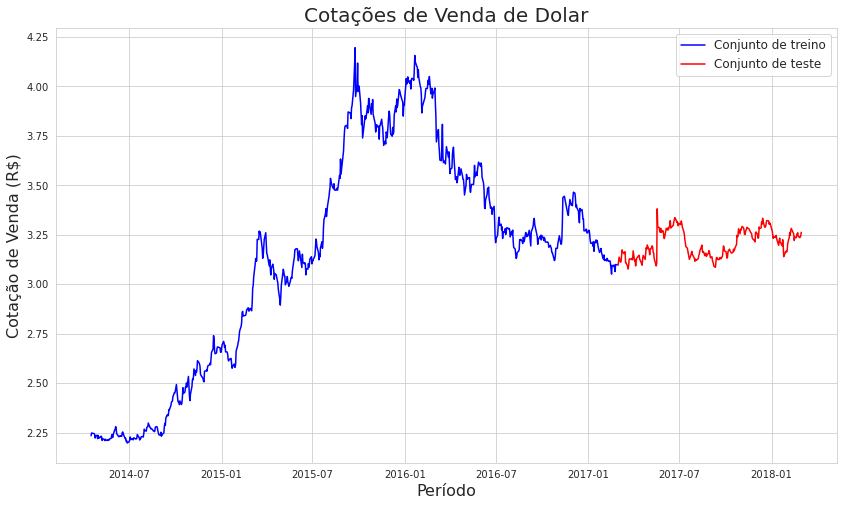

In [246]:
# Gráfico mostrando conjunto de treino e de teste para as redes neurais
plt.plot(dados[:datetime.strptime(dia_corte, "%Y-%m-%d")+timedelta(days=1)].index[tam_janela:], 
         janelas_y[:n_train+1], "b-", label="Conjunto de treino")
plt.plot(dias_teste, y_test, "r-", label="Conjunto de teste")
plt.title("Cotações de Venda de %s"%(moeda), fontsize=20)
plt.xlabel("Período", fontsize=16)
plt.ylabel("Cotação de Venda (R$)", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [320]:
# criar modelo de redes neurais
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=10, activation='elu', padding="causal",
                              input_shape=(tam_janela, 1)))
model.add(keras.layers.MaxPooling1D(pool_size=5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(30, activation='elu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

# treinar modelo
_ = model.fit(x_train, y_train, epochs=100, verbose=0)

# Exibe erro MSE para conjunto de treino
model.evaluate(x_train, y_train)

23/23 [==============================] - 0s 4ms/step - loss: 0.0036


0.0035663999151438475

In [324]:
# salvar modelo
model.save("keras_dolar_%dd.h5"%N)

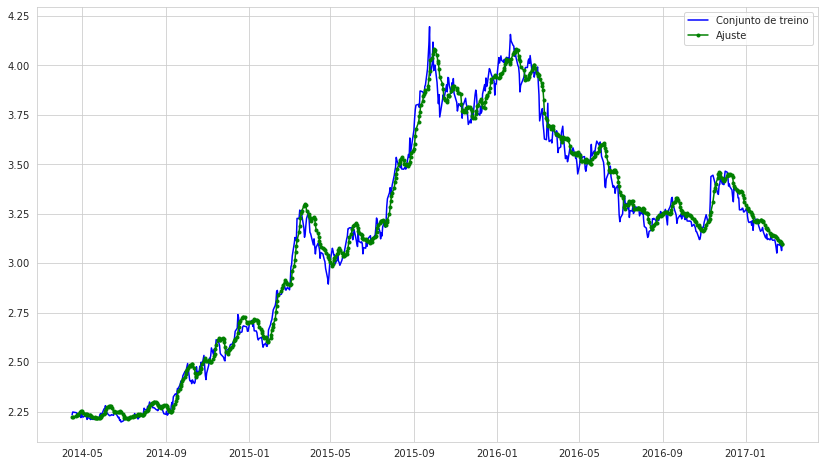

In [321]:
# carregar modelo
#model = keras.models.load_model("keras_dolar_%dd.h5"%7)

# Plotando previsões versus real do conjunto de treino
y_train_pred = model.predict(x_train).reshape(-1)

plt.plot(dias_treino, y_train, "b-", label="Conjunto de treino")
plt.plot(dias_treino, y_train_pred, "g.-", label="Ajuste")
plt.legend(loc=1)
plt.show()

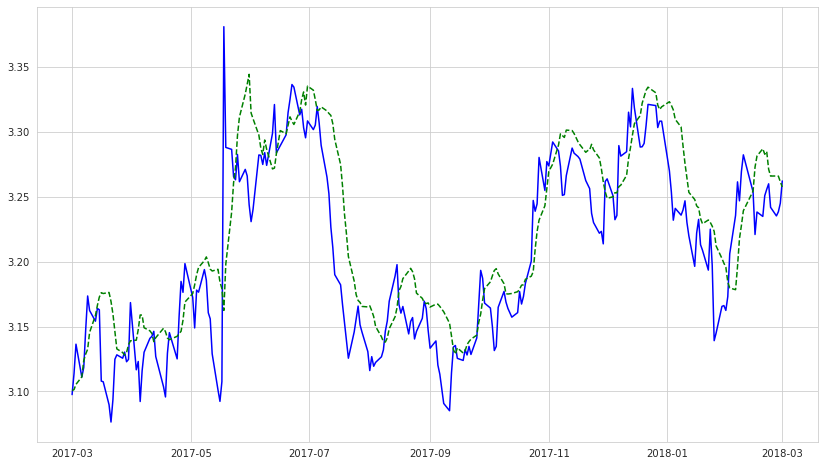

8/8 [==============================] - 0s 6ms/step - loss: 0.0017


0.0016896226443350315

In [322]:
# Plotando previsões versus real do conjunto de teste
y_keras = model.predict(x_test).reshape(-1)
plt.plot(dias_teste, y_test, "b-", label="Cotação real")
plt.plot(dias_teste, y_keras, "g--", label="Previsão Keras")
plt.show()
model.evaluate(x_test, y_test)

## Bloco do Arima

In [251]:
# Autocorrelação
def plotar_autocorrelacoes(campo, lags=10):
    '''(np.array, int) -> None'''
    fig, ax = plt.subplots(1, 2, figsize=(16.5, 5))
    acf = plot_acf(campo, lags=lags, ax=ax[0], title="ACF")
    pacf = plot_pacf(campo, lags=lags, ax=ax[1], title="PACF")
    plt.tight_layout()
    plt.show()

correlacoes = np.zeros(N)
corr_parciais = np.zeros(N)

for i in range(N):
    #plotar_autocorrelacoes(x_arima[i])
    
    # Calculando correlações
    ac, conf = acf(x_arima[i], nlags=5, alpha=0.05)
    conf_mean = (conf[:,0]+conf[:,1])/2
    conf_up = conf[:,1]-conf_mean
    conf_down = conf[:,0]-conf_mean
    
    # testando se a autocorrelação está no intervalo de confiança do zero
    for k in range(len(ac)):
        if not conf_down[k] < ac[k] < conf_up[k]:
            correlacoes[i] = k
            
    # Calculando correlações parciais
    pac, conf = pacf(x_arima[i], nlags=5, alpha=0.05)
    conf_mean = (conf[:,0]+conf[:,1])/2
    conf_up = conf[:,1]-conf_mean
    conf_down = conf[:,0]-conf_mean
    
    # testando se a autocorrelação parcial está no intervalo de confiança do zero
    for k in range(len(ac)):
        if not conf_down[k] <= pac[k] <= conf_up[k]:
            corr_parciais[i] = k

# Exibe o maior coeficiente correlacionado para cada dia de teste
print(correlacoes)
print(corr_parciais)

[2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 2. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 2.
 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2.
 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 2. 2. 2. 3. 3. 2. 2. 2. 2. 2. 2. 2. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 4. 1. 1. 1. 5. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 

#### Parâmetros do modelo Arima

    *p é a ordem do componente autoregressiva
    *d é o número de diferenças tomadas na série
    *q é a ordem da componente de médias móveis

In [252]:
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))[1:] # ignorando (0, 0, 0
#print(pdq)

In [253]:
# construindo uma busca de parâmetros ótimos
best_params = []

for k in tqdm(range(N)):
    params = None
    best_aic = float("inf")
    for param in pdq:
        try:
            mod = ARIMA(x_arima[k], order=param)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                params = param
        except:
            continue

    # Salva o melhor modelo encontrado
    best_params.append(params)
    #print("AIC:%f"%(best_aic))

In [254]:
# Salvando Modelo
outfile = open("arima_%dd.dill"%N, 'wb')
dill.dump(best_params, outfile)
outfile.close()

In [259]:
# Recuperando Modelo salvo
infile = open("arima_%dd.dill"%N,'rb')
best_params = dill.load(infile)
infile.close()

# Exibe qual o melhor modelo encontrado
print(len(best_params))
#for k in range(N):
    #print("ARIMA %s" %(list(best_params[k])))

250


In [260]:
# Previsões das múltiplas janelas
y_arima = []
for k in range(N):
    modelo = ARIMA(x_arima[k], order=best_params[k]).fit()
    y_arima.append(modelo.forecast()[0][0])
    #print(modelo.forecast())

### Bloco Perceptron

In [261]:
y_percep_train = y_train.copy().reshape(-1, 1)
x_percep_train = x_train.copy().reshape(len(x_train), -1)
x_percep_test = x_test.copy().reshape(len(x_test), -1)

In [262]:
perceptron = Perceptron(taxa=0.001, ativacao="elu", N=[20, 10, 1])
perceptron.treinar(x_percep_train, y_percep_train, M=25)

In [224]:
# Recuperando Modelo salvo
infile = open("perceptron_%dd.dill"%7,'rb')
perceptron = dill.load(infile)
infile.close()

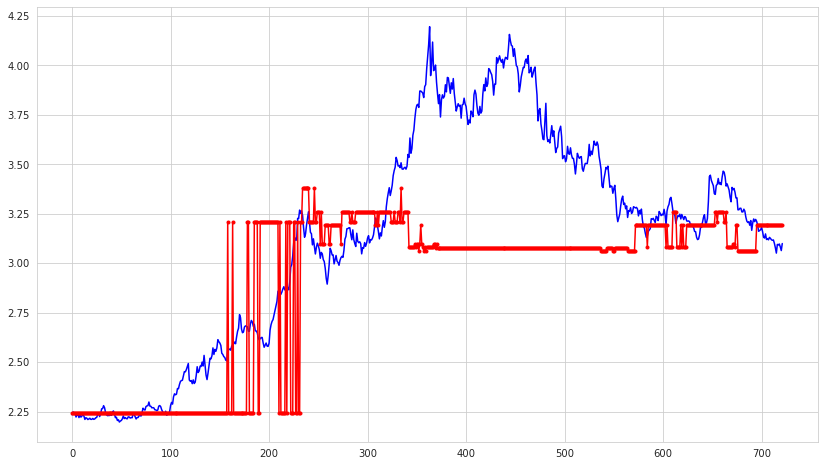

In [265]:
y_percep_train_pred = perceptron.prever(x_percep_train)
plt.plot(y_train, "b-")
plt.plot(y_percep_train_pred, "r.-")
plt.show()

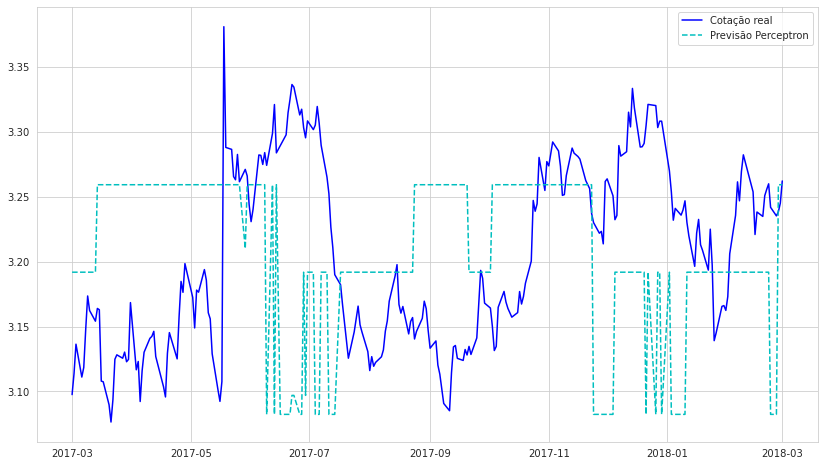

In [326]:
y_percep = perceptron.prever(x_percep_test)
y_percep = y_percep.reshape(-1)

plt.plot(dias_teste, y_test, "b-", label="Cotação real")
plt.plot(dias_teste, y_percep, "c--", label="Previsão Perceptron")
plt.legend(loc=0)
plt.show()

## Modelos de Referência

In [267]:
# Modelo de referência média-móvel da janela
y_mean = []
for k in range(N):
    y_mean.append(np.mean(x_test[k]))
y_mean = np.array(y_mean)

In [350]:
# Modelo de referência média-móvel de 7 dias
janelas_x_7, janelas_y_7 = gerar_janelas(dados.cotacao, 7)

# janelas de teste (7 dias)
x_test_7 = janelas_x_7[-N:].reshape((N, 7, 1))
y_test_7 = janelas_y_7[-N:]

y_mean_7 = []
for k in range(N):
    y_mean_7.append(np.mean(x_test_7[k]))
y_mean_7 = np.array(y_mean_7)

# Plotando tudo junto

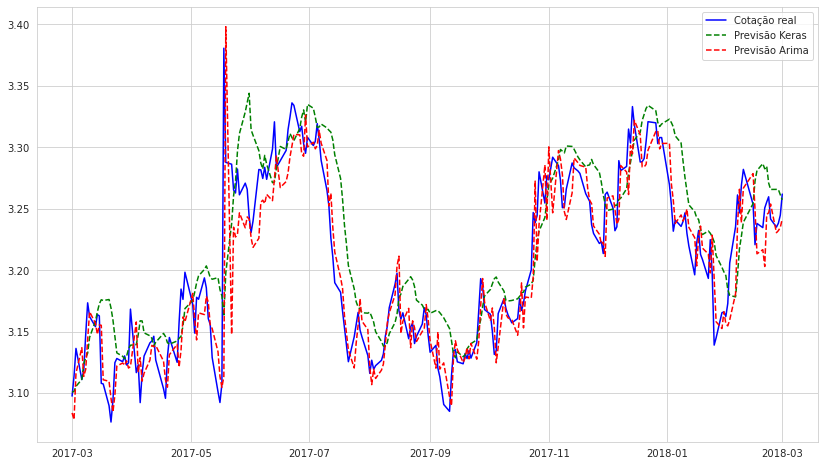

In [353]:
# Plotando tudo junto
plt.plot(dias_teste, y_test, "b-", label="Cotação real")
plt.plot(dias_teste, y_keras, "g--", label="Previsão Keras")
plt.plot(dias_teste, y_arima, "r--", label="Previsão Arima")
plt.legend(loc=0)
plt.show()

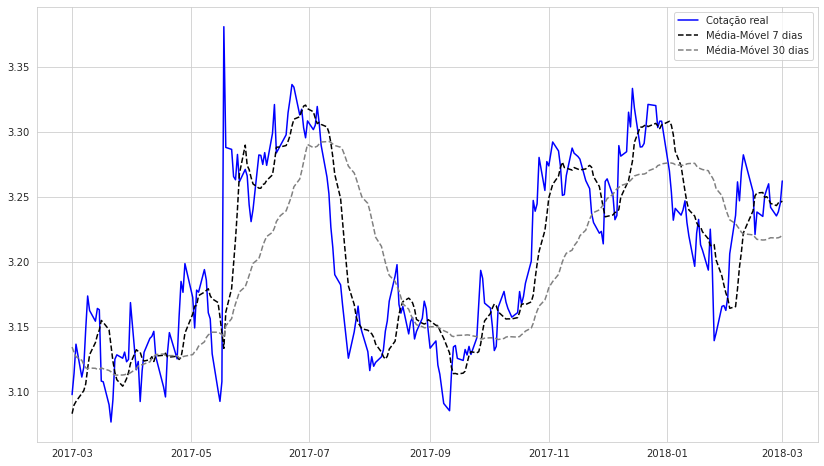

In [352]:
# Plotando tudo junto
plt.plot(dias_teste, y_test, "b-", label="Cotação real")
plt.plot(dias_teste, y_mean_7, "--", color="black", label="Média-Móvel 7 dias")
plt.plot(dias_teste, y_mean, "--", color="gray", label="Média-Móvel 30 dias")
plt.legend(loc=0)
plt.show()

In [ ]:
for k in range(N):
    print("%s & %.2f & %.2f & %.2f & %.2f & %.2f \\\\"%(dias_teste[k].date().strftime("%d/%m/%Y"), 
                                               y_test[k], y_mean[k], y_arima[k], y_keras[k], y_percep[k]))

In [355]:
# erro MAE = erro absoluto médio
print("MAE: Média-Móvel 7d, Média-Móvel 30d, Arima, Keras, Perceptron")
print("& - & %.3f & %.3f & %.3f & %.3f & %.3f \\\\" %(np.mean(np.abs(y_mean_7 - y_test)),
                                                      np.mean(np.abs(y_mean - y_test)),
                                                      np.mean(np.abs(y_arima - y_test)),
                                                      np.mean(np.abs(y_keras - y_test)),
                                                      np.mean(np.abs(y_percep - y_test)) ))
# erro RMSE = raiz do erro quadrático médio
print("\nRMSE: Média-Móvel 7d, Média-Móvel 30d, Arima, Keras, Perceptron")
print("& - & %.3f & %.3f & %.3f & %.3f & %.3f \\\\" %(np.sqrt(np.mean((y_mean_7 - y_test)**2)),
                                                      np.sqrt(np.mean((y_mean - y_test)**2)),
                                                      np.sqrt(np.mean((y_arima - y_test)**2)),
                                                      np.sqrt(np.mean((y_keras - y_test)**2)),
                                                      np.sqrt(np.mean((y_percep - y_test)**2)) ))
# Correlação de Pearson
print("\nPearson: Média-Móvel 7d, Média-Móvel 30d, Arima, Keras, Perceptron")
print("& - & %.3f & %.3f & %.3f & %.3f & %.3f \\\\" %(np.corrcoef(y_test, y_mean_7)[0, 1],
                                                      np.corrcoef(y_test, y_mean)[0, 1],
                                                      np.corrcoef(y_test, y_arima)[0, 1],
                                                      np.corrcoef(y_test, y_keras)[0, 1],
                                                      np.corrcoef(y_test, y_percep)[0, 1] ))

MAE: Média-Móvel 7d, Média-Móvel 30d, Arima, Keras, Perceptron
& - & 0.026 & 0.045 & 0.019 & 0.031 & 0.088 \\

RMSE: Média-Móvel 7d, Média-Móvel 30d, Arima, Keras, Perceptron
& - & 0.036 & 0.057 & 0.030 & 0.041 & 0.108 \\

Pearson: Média-Móvel 7d, Média-Móvel 30d, Arima, Keras, Perceptron
& - & 0.857 & 0.615 & 0.906 & 0.850 & -0.397 \\
